In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
df = pd.read_csv("/content/drive/MyDrive/Python+for+Financial+Analysis+-+Course+Package/Part 3. AI and ML in Finance/stock_sentiment.csv")

In [37]:
nltk.download("stopwords")
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
# Step 1: process data
def text_processing(df):

  # Remove punctuation
  def remove_punc(text):
    return text.translate(str.maketrans('', '', string.punctuation))
  
  # Update data
  df['Text Without Punctuation'] = df['Text'].apply(remove_punc)

  # Filter out stopwords
  def preprocess(text):
    
    final = []
    for token in gensim.utils.simple_preprocess(text):
      if len(token) > 2 and token not in stopwords:
        final.append(token)
    return final

  # Update data
  df['Text Without Punctuation and Stopwords'] = df['Text Without Punctuation'].apply(preprocess)

  # Get list and number of words in data
  words_list = []
  for words in df['Text Without Punctuation and Stopwords']:
    for word in words:
      words_list.append(word)
  num_words = len(set(words_list))
  
  return df

In [62]:
def sentiment_analysis(df):

  df = text_processing(df)

  X = df['Text Without Punctuation and Stopwords']
  y = df['Sentiment']

  # Step 2: tokenizing and padding

  # Choose proportion of data to train and test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

  # Tokenize words
  tokenizer = Tokenizer(num_words)
  tokenizer.fit_on_texts(X_train)
  
  train_sequences = tokenizer.texts_to_sequences(X_train)
  test_sequences = tokenizer.texts_to_sequences(X_test)

  # Padding
  padded_train = pad_sequences(train_sequences, maxlen = 29, padding = 'post', truncating = 'post')
  padded_test = pad_sequences(test_sequences, maxlen = 29, truncating = 'post')

  # Categorical 2D representation 
  cat_y_train = to_categorical(y_train, 2)
  cat_y_test = to_categorical(y_test, 2)

  # Sequential Model
  model = Sequential()

  # Embedding layer
  model.add(Embedding(num_words, output_dim = 512))

  model.add(LSTM(256))

  # Dense layers
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(2, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

  # Step 3: train the model
  model.fit(padded_train, cat_y_train, batch_size = 32, validation_split = 0.2, epochs = 2)

  # Step 4: test the model
  predicted = model.predict(padded_test)

  prediction = []
  for i in predicted:
    prediction.append(np.argmax(i))

  original = []
  for i in cat_y_test:
    original.append(np.argmax(i))

  # Step 5: analysis of the model
  accuracy = accuracy_score(original, prediction)
  
  sns.heatmap(confusion_matrix(original, prediction), annot = True)

  return print("The model has an accuracy of:", accuracy), sns.heatmap(confusion_matrix(original, prediction), annot = True)


Epoch 1/2
131/131 [==============================] - 49s 350ms/step - loss: 0.6583 - acc: 0.6454 - val_loss: 0.6699 - val_acc: 0.6174
Epoch 2/2
131/131 [==============================] - 43s 326ms/step - loss: 0.6117 - acc: 0.6843 - val_loss: 0.5182 - val_acc: 0.7632
The model has an accuracy of: 0.6379310344827587


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7f520f374e10>)

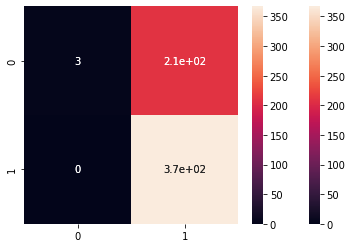

In [63]:
sentiment_analysis(df)